# CE-40959: Advanced Machine Learning
## HW4 - Multi-task and goal conditioned RL

#### Name: Sepehr Ghobadi
#### Student No.: 400211008

In this assignment we will be looking at goal-conditioned reinforcement learning and
hindsight experience replay (HER). In particular, you will:
1. Adapt an existing model (a Deep Q-Network) to be goal-conditioned
2. Implement Hindsight Experience Replay (HER) on top of a goal-conditioned
DQN
3. Compare the performance with and without HER


In this assignment, we will be running goal-conditioned Q-learning on two problems:
**(a)** a toy problem where we flip bits in a bit vector to match it to the current goal vector
and **(b)** move the end effector of a simulated robotic arm to the desired goal position

<font color='red'>Submission: To submit your homework, submit this notebook written answers and Tensorboard graphs screenshots to the questions
below</font>

**Environment 1:** Bit Flipping Environment
In the bit-flipping environment, the state is a binary vector with length n. The goal is to
reach a known goal vector, which is also a binary vector with length n. At each step, we can
flip a single value in the vector (changing a 0 to 1 or a 1 to 0). This environment can very
easily be solved without reinforcement learning, but we will use a DQN to understand
how adding HER can improve performance.
The bit flipping environment is an example of an environment with sparse rewards. At
each step, we receive a reward of -1 when the goal and state vector do not match and
a reward of 0 when they do. With a larger vector size, we receive fewer non-negative
rewards.


**Environment 2:** 2D Sawyer Arm
The Sawyer Arm is a multi-jointed robotic arm for grasping and reaching (https://robots.
ieee.org/robots/sawyer/). The arm operates in a 2D space, and the goal is to move the
robot to a set of coordinates. The sawyer reach is an example of a dense reward environment, where the reward is given by negative Euclidean distance between the robot arm
and the goal state.

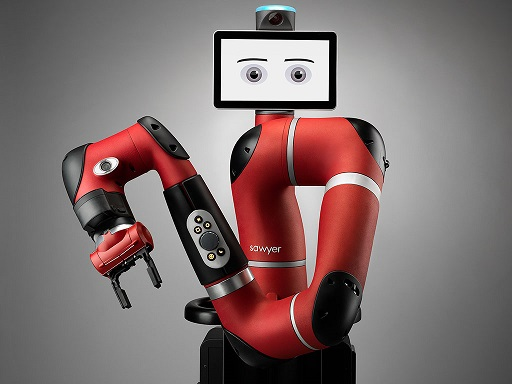

#installation

In [1]:
# !pip3 install imgaug==0.2.5
# !pip3 install tensorflow-probability==0.7.0
# !apt-get install -y \
#     libgl1-mesa-dev \
#     libgl1-mesa-glx \
#     libglew-dev \
#     libosmesa6-dev \
#     software-properties-common

# !apt-get install -y patchelf
# !pip3 install gym==0.15.7
# !pip3 install free-mujoco-py

In [4]:
!git clone https://github.com/vitchyr/multiworld.git
!pip install -e ./multiworld
!pip install pygame
!pip3 install -U 'mujoco-py<2.2,>=2.1'

fatal: destination path 'multiworld' already exists and is not an empty directory.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Obtaining file:///Users/sepehr/Desktop/UNI/Courses/AdvancedML/AML_HW4/Practical/AML_HW4_Q3/multiworld
  Preparing metadata (setup.py) ... done
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Running setup.py develop for multiworld
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils import tensorboard
import gym
import multiworld
import mujoco_py 
import random

import bit_flip_env
import sawyer_action_discretize
from utils import HERType
import replay_buffer as experience_buffer
import q_network
import utils
from utils import HERType

pygame 2.1.2 (SDL 2.0.18, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
'''Test dependencies.'''
import sawyer_action_discretize
multiworld.register_all_envs()

if __name__ == '__main__':
    env = gym.make('SawyerReachXYEnv-v1')
    env = sawyer_action_discretize.SawyerActionDiscretize(
            env, render_every_step=False)
    env.reset()
    for _ in range(10):
        env.step(0)

    print('\n\nDependencies successfully installed!\n\n')




Dependencies successfully installed!




#Implementation (10 points)

##run_episode (5 points)

In [4]:
"""Complete the code marked TODO."""

def run_episode(
    env,
    q_net, # pylint: disable=unused-argument
    steps_per_episode,
):
    """Runs the current policy on the given environment.

    Args:
        env (gym): environment to generate the state transition
        q_net (QNetwork): Q-Network used for computing the next action
        steps_per_episode (int): number of steps to run the policy for

    Returns:
        episode_experience (list): list containing the transitions
                        (state, action, reward, next_state, goal_state)
        episodic_return (float): reward collected during the episode
        succeeded (bool): DQN succeeded to reach the goal state or not
    """

    # list for recording what happened in the episode
    episode_experience = []
    succeeded = False
    episodic_return = 0.0

    # reset the environment to get the initial state
    state, goal_state = env.reset() # pylint: disable=unused-variable

    for _ in range(steps_per_episode):

        # ======================== TODO modify code ========================

        # append goal state to input, and prepare for feeding to the q-network
        state_goal_concat = torch.from_numpy(np.append(state, goal_state).astype(np.float32))

        # forward pass to find action
        with torch.no_grad():
            action = torch.argmax(q_net(state_goal_concat))

        # take action, use env.step
        next_state, reward, done, info = env.step(action.item())

        # add transition to episode_experience as a tuple of
        # (state, action, reward, next_state, goal)
        episode_experience.append( (state, action, reward, next_state, goal_state) )
        
        # update episodic return
        episodic_return += reward

        # update state
        state = next_state

        # update succeeded bool from the info returned by env.step
        succeeded = info['successful_this_state']

        # break the episode if done=True
        if done:
            break

        # ========================      END TODO       ========================

    return episode_experience, episodic_return, succeeded


##update_replay_buffer (5 points)

In [5]:
"""Main training loop used for training both sawyer_main and bit flipping.

Modify the code in the sections marked TODO."""


def update_replay_buffer(
    replay_buffer,
    episode_experience,
    her_type=HERType.NO_HINDSIGHT,
    env_reward_function=None, # pylint: disable=unused-argument
    num_relabeled=4, # pylint: disable=unused-argument
):
    """Adds past experience to the replay buffer. Training is done with
    episodes from the replay buffer. When HER is used, relabeled
    experiences are also added to the replay buffer.

    Args:
        replay_buffer (ReplayBuffer): replay buffer to store experience
        episode_experience (list): list containing the transitions
            (state, action, reward, next_state, goal_state)
        HER (HERType): type of hindsight experience replay to use
        env_reward_function ((ndarray, ndarray) -> float):
            reward function for relabelling transitions
        num_relabeled (int): number of relabeled transition per transition
    """

    for timestep in range(len(episode_experience)):

        # copy experience from episode_experience to replay_buffer
        state, action, reward, next_state, goal = episode_experience[timestep]
        # use replay_buffer.add
        replay_buffer.add(np.append(state, goal),
                          action,
                          reward,
                          np.append(next_state, goal))

        # ======================== TODO modify code ========================

        if her_type == HERType.FINAL:
            # relabel episode based on final state in episode

            # get final goal
            imagined_goal = episode_experience[-1][3]

            # compute new reward
            new_reward = env_reward_function(state, imagined_goal)

            # add to buffer
            replay_buffer.add(np.append(state, imagined_goal),
                  action,
                  new_reward,
                  np.append(next_state, imagined_goal))

        elif her_type == HERType.FUTURE:
            # future: relabel episode based on randomly sampled future state.
            # At each timestep t, relabel the goal with a randomly selected
            # timestep between t and the end of the episode

            # for every transition, add num_relabeled transitions to the buffer

            # get random future goal
            imagined_goals = [s[3] for s in random.sample(episode_experience[timestep:], min(num_relabeled, len(episode_experience)-timestep))]

            # compute new reward
            new_rewards = [env_reward_function(state, g) for g in imagined_goals]

            # add to replay buffer
            for new_reward, imagined_goal in zip(new_rewards, imagined_goals):
                replay_buffer.add(np.append(state, imagined_goal),
                  action,
                  new_reward,
                  np.append(next_state, imagined_goal))

        elif her_type == HERType.RANDOM:
            # random: relabel episode based on a random state from the episode

            # for every transition, add num_relabeled transitions to the buffer

            # get random goal
            imagined_goals = [s[3] for s in random.sample(episode_experience, min(num_relabeled,len(episode_experience)))]

            # compute new reward
            new_rewards = [env_reward_function(state, g) for g in imagined_goals]

            # add to replay buffer
            for new_reward, imagined_goal in zip(new_rewards, imagined_goals):
                replay_buffer.add(np.append(state, imagined_goal),
                  action,
                  new_reward,
                  np.append(next_state, imagined_goal))

        # ========================      END TODO       ========================

def train(
    env,
    input_dim,
    action_dim,
    num_epochs,
    writer,
    her_type=HERType.NO_HINDSIGHT,
    env_reward_function=None,
    num_relabeled=4,
    buffer_size=1e6,
    num_episodes=16,
    steps_per_episode=50,
    gamma=0.98,
    opt_steps=40,
    batch_size=128,
    log_interval=5,
):
    """Main loop for training DQN on the sawyer environment. The DQN is
    trained for num_epochs. In each epoch, the agent runs in the environment
    num_episodes number of times. The Q-target and Q-policy networks are
    updated at the end of each epoch. Within one episode, Q-policy attempts
    to solve the environment and is limited to the same number as steps as the
    size of the environment.

    Args:
        env (gym object): main environment to sample transitions.
        input_dim (int): input size for the Q-network.
        action_dim (int): action space for the environment,
            output dim for Q-network.
        num_epochs (int): number of epochs to train DQN for
        her_type (HERType): Specify version of hindsight experience replay,
            defaults to None
        num_relabeled (int): number of relabelled trajectories per
            collected trajectory when using HER
        buffer_size (int): number of recent experiences to store in the
            replay buffer
        num_episodes (int): number of goals attempted per epoch
        steps_per_episode (int): number of steps_per_episode
        gamma (float): discount factor for RL
        opt_steps (int): number of gradient steps per epoch
        batch_size (int): number of transitions sampled from the
            replay buffer per optimization step
        writer (tensorboard.SummaryWriter): tensorboard event logger
        log_interval (int): frequency for recording tensorboard events
    """

    # create replay buffer
    replay_buffer = experience_buffer.Buffer(buffer_size, batch_size)

    # set up Q-policy (model) and Q-target (target_model)
    model = q_network.QNetwork(input_dim, action_dim)
    target_model = q_network.QNetwork(input_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # start by making Q-target and Q-policy the same
    utils.update_target(model, target_model)

    # Run for a fixed number of epochs
    for epoch_idx in range(num_epochs):
        # total reward for the epoch
        total_reward = 0.0
        # record success rate for each episode of the epoch
        successes = []
        # loss at the end of each epoch
        losses = []

        for _ in range(num_episodes):
            # collect data in the environment
            episode_experience, ep_reward, succeeded = run_episode(
                env, model, steps_per_episode)
            # track eval metrics in the environment
            total_reward += ep_reward
            successes.append(succeeded)
            # add to the replay buffer; use specified HER policy
            update_replay_buffer(
                replay_buffer,
                episode_experience,
                her_type=her_type,
                env_reward_function=env_reward_function,
                num_relabeled=num_relabeled
            )

        # optimize the Q-policy network
        for _ in range(opt_steps):
            # sample from the replay buffer
            state, action, reward, next_state = replay_buffer.sample()
            state = torch.from_numpy(state.astype(np.float32))
            action = torch.from_numpy(action)
            reward = torch.from_numpy(reward.astype(np.float32))
            next_state = torch.from_numpy(next_state.astype(np.float32))

            optimizer.zero_grad()
            # forward pass through target network
            target_q_vals = target_model(next_state).detach()
            # calculate target reward
            q_loss_target = torch.clip(
                reward + gamma * torch.max(target_q_vals, axis=-1).values,
                -1.0 / (1 - gamma),
                0)
            # calculate predictions and loss
            model_predict = model(state)
            model_action_taken = torch.reshape(action, [-1])
            action_one_hot = nn.functional.one_hot(
                model_action_taken, action_dim)
            q_val = torch.sum(model_predict * action_one_hot, axis=1)
            criterion = nn.MSELoss()
            loss = criterion(q_val, q_loss_target)
            losses.append(loss.detach().numpy())

            loss.backward()
            optimizer.step()

        # update target model by copying Q-policy to Q-target
        utils.update_target(model, target_model)

        if epoch_idx % log_interval == 0:
            print(
                f"Epoch: {epoch_idx} Cumulative reward: {total_reward} Success rate: {np.mean(successes)} Mean loss: {np.mean(losses)}" # pylint: disable=line-too-long
            )
            writer.add_scalar(
                "eval_metrics/total_reward", total_reward, epoch_idx)
            writer.add_scalar(
                "eval_metrics/success_rate", np.mean(successes), epoch_idx)
            writer.add_scalar(
                "train_metrics/td_loss", np.mean(losses), epoch_idx)


In [6]:
def main(log_dir=None, env='bit_flip', num_bits=7, num_epochs=250, her_type='no_hindsight', random_seed=42):
    multiworld.register_all_envs()

    torch.manual_seed(random_seed)

    if env == 'bit_flip':
        env = bit_flip_env.BitFlipEnv(num_bits)
        input_dim = 2 * num_bits
        action_dim = num_bits
        steps_per_episode = num_bits
        env_reward_function = lambda x, y: 0.0 if np.array_equal(x, y) else -1.0
        tensorboard_log_dir = (
            f'./logs/gcrl/bit_flip/num_bits:{num_bits}/HER_type:{her_type}/seed:{random_seed}' # pylint: disable=line-too-long
        ) if log_dir is None else log_dir

    elif env == 'sawyer_reach':
        env = gym.make('SawyerReachXYEnv-v1')
        env = sawyer_action_discretize.SawyerActionDiscretize(
            env, render_every_step=False)
        input_dim = 4
        action_dim = 4
        steps_per_episode = 50
        env_reward_function = lambda x, y: -np.linalg.norm(x - y)
        tensorboard_log_dir = (
            f'./logs/gcrl/sawyer_reach/HER_type:{her_type}/seed:{random_seed}' # pylint: disable=line-too-long
        ) if log_dir is None else log_dir

    print(f'logging experiment at: {tensorboard_log_dir}')
    writer = tensorboard.SummaryWriter(log_dir=tensorboard_log_dir)
    train(
        env=env,
        input_dim=input_dim,
        action_dim=action_dim,
        env_reward_function=env_reward_function,
        num_epochs=num_epochs,
        steps_per_episode=steps_per_episode,
        her_type=HERType[her_type.upper()],
        writer=writer,
    )

# Problem 1: Implementing Goal-conditioned RL (5 points)

We have a goal-conditioned DQN. The Q-function takes in the concatenated state and
goal as input. You can think of the goal-conditioned implementation as an extended
Markov decision process (MDP), where your state space contains both the original state
and the goal

In [8]:
main(env='bit_flip', num_bits=6, num_epochs=250, her_type='no_hindsight')

logging experiment at: ./logs/gcrl/bit_flip/num_bits:6/HER_type:no_hindsight/seed:42
Epoch: 0 Cumulative reward: -90.0 Success rate: 0.0625 Mean loss: 0.1730031669139862
Epoch: 5 Cumulative reward: -86.0 Success rate: 0.125 Mean loss: 0.11783089488744736
Epoch: 10 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.10191573947668076
Epoch: 15 Cumulative reward: -69.0 Success rate: 0.3125 Mean loss: 0.09191618114709854
Epoch: 20 Cumulative reward: -85.0 Success rate: 0.125 Mean loss: 0.09129605442285538
Epoch: 25 Cumulative reward: -93.0 Success rate: 0.0625 Mean loss: 0.07379555702209473
Epoch: 30 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.06752097606658936
Epoch: 35 Cumulative reward: -84.0 Success rate: 0.125 Mean loss: 0.06396953761577606
Epoch: 40 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.060807965695858
Epoch: 45 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.05615241080522537
Epoch: 50 Cumulative reward: -73.0 Success rate: 0.25 Mean loss: 

<font color='red'>Verify the eval metrics, that is total reward should be above -40.0 and success rate
should be 1.0. </font>

In [1]:
%load_ext tensorboard

In [2]:
%tensorboard --logdir ./logs/gcrl/bit_flip/num_bits:6/HER_type:no_hindsight/seed:42

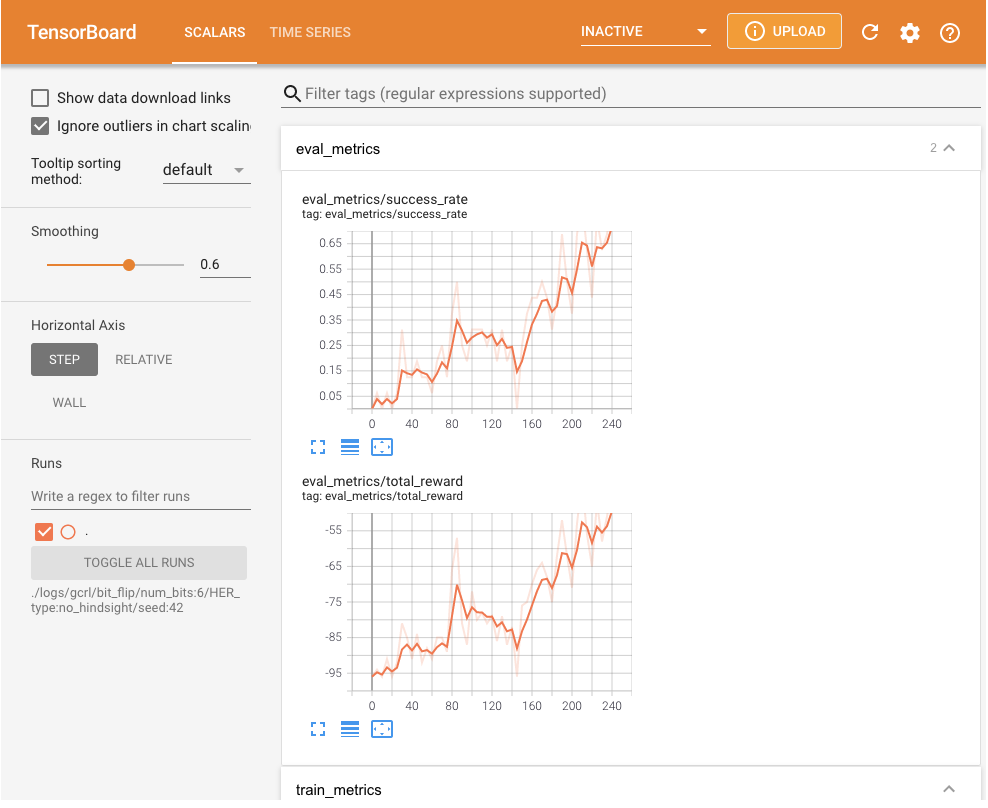

#Problem 2: Adding HER to Bit Flipping (8 points)

With HER, the model is trained on the actual (state, goal, reward) tuples along with (state,
goal, reward) tuples where the goal has been relabeled. The goals are relabeled to be what
state was actually reached and the rewards correspondingly relabeled. In other words, we
pretend that the state we reached was always our goal. HER gives us more examples of
actions that lead to positive rewards. The reward function for relabeled goals is the same
as the environment reward function; for the bit flipping environment, the reward is -1 if
the state and goal vector do not match and 0 if they do match.

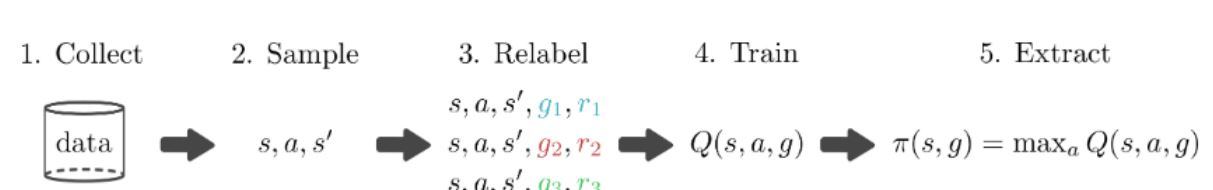

There are three different variations of HER: final, random, and future. In each variation,
the goal is relabeled differently:

• final: The final state of the episode is used as the goal

• random: A random state in the episode is used as the goal

• future: A random future state of the episode is used as the goal


In [22]:
#main(env='bit_flip', num_bits=6, num_epochs=250, her_type='no_hindsight') # duplicate of last run. ruins graph 
main(env='bit_flip', num_bits=15, num_epochs=500, her_type='no_hindsight')

logging experiment at: ./logs/gcrl/bit_flip/num_bits:6/HER_type:no_hindsight/seed:42
Epoch: 0 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.19751809537410736
Epoch: 5 Cumulative reward: -94.0 Success rate: 0.0625 Mean loss: 0.12502112984657288
Epoch: 10 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.1060277447104454
Epoch: 15 Cumulative reward: -91.0 Success rate: 0.0625 Mean loss: 0.09552077203989029
Epoch: 20 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.08423155546188354
Epoch: 25 Cumulative reward: -92.0 Success rate: 0.0625 Mean loss: 0.07527877390384674
Epoch: 30 Cumulative reward: -81.0 Success rate: 0.3125 Mean loss: 0.06654300540685654
Epoch: 35 Cumulative reward: -85.0 Success rate: 0.125 Mean loss: 0.06365206092596054
Epoch: 40 Cumulative reward: -91.0 Success rate: 0.125 Mean loss: 0.05627230554819107
Epoch: 45 Cumulative reward: -84.0 Success rate: 0.1875 Mean loss: 0.0472840741276741
Epoch: 50 Cumulative reward: -92.0 Success rate: 0.125 Mean 

Epoch: 215 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.016316063702106476
Epoch: 220 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.01923135295510292
Epoch: 225 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.02005092427134514
Epoch: 230 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.017498880624771118
Epoch: 235 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.01929778978228569
Epoch: 240 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.02126973494887352
Epoch: 245 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.018263686448335648
Epoch: 250 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.01794223114848137
Epoch: 255 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.01967509649693966
Epoch: 260 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.016314908862113953
Epoch: 265 Cumulative reward: -240.0 Success rate: 0.0 Mean loss: 0.016254547983407974
Epoch: 270 Cumulative reward: -240.0 Success rate

In [15]:
main(env='bit_flip', num_bits=6, num_epochs=250, her_type='final')
main(env='bit_flip', num_bits=15, num_epochs=500, her_type='final')

logging experiment at: ./logs/gcrl/bit_flip/num_bits:6/HER_type:final/seed:42
Epoch: 0 Cumulative reward: -84.0 Success rate: 0.125 Mean loss: 0.1943902224302292
Epoch: 5 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.14223860204219818
Epoch: 10 Cumulative reward: -86.0 Success rate: 0.125 Mean loss: 0.11721746623516083
Epoch: 15 Cumulative reward: -76.0 Success rate: 0.3125 Mean loss: 0.12866753339767456
Epoch: 20 Cumulative reward: -44.0 Success rate: 0.8125 Mean loss: 0.1180189847946167
Epoch: 25 Cumulative reward: -39.0 Success rate: 0.875 Mean loss: 0.10133783519268036
Epoch: 30 Cumulative reward: -30.0 Success rate: 1.0 Mean loss: 0.09741207212209702
Epoch: 35 Cumulative reward: -35.0 Success rate: 1.0 Mean loss: 0.09044896066188812
Epoch: 40 Cumulative reward: -35.0 Success rate: 1.0 Mean loss: 0.08757269382476807
Epoch: 45 Cumulative reward: -26.0 Success rate: 1.0 Mean loss: 0.08981844037771225
Epoch: 50 Cumulative reward: -34.0 Success rate: 1.0 Mean loss: 0.08336618

Epoch: 220 Cumulative reward: -107.0 Success rate: 1.0 Mean loss: 0.07490070909261703
Epoch: 225 Cumulative reward: -101.0 Success rate: 0.9375 Mean loss: 0.06786907464265823
Epoch: 230 Cumulative reward: -101.0 Success rate: 1.0 Mean loss: 0.07133112847805023
Epoch: 235 Cumulative reward: -106.0 Success rate: 1.0 Mean loss: 0.07346758991479874
Epoch: 240 Cumulative reward: -131.0 Success rate: 0.875 Mean loss: 0.07040247321128845
Epoch: 245 Cumulative reward: -94.0 Success rate: 1.0 Mean loss: 0.06946142762899399
Epoch: 250 Cumulative reward: -100.0 Success rate: 1.0 Mean loss: 0.07220008224248886
Epoch: 255 Cumulative reward: -105.0 Success rate: 1.0 Mean loss: 0.06991702318191528
Epoch: 260 Cumulative reward: -106.0 Success rate: 0.9375 Mean loss: 0.0711185485124588
Epoch: 265 Cumulative reward: -120.0 Success rate: 1.0 Mean loss: 0.0675123929977417
Epoch: 270 Cumulative reward: -131.0 Success rate: 0.875 Mean loss: 0.06793742626905441
Epoch: 275 Cumulative reward: -95.0 Success rat

In [17]:
main(env='bit_flip', num_bits=6, num_epochs=250, her_type='random')
main(env='bit_flip', num_bits=15, num_epochs=500, her_type='random')

logging experiment at: ./logs/gcrl/bit_flip/num_bits:6/HER_type:random/seed:42
Epoch: 0 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.2087278813123703
Epoch: 5 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.1087120771408081
Epoch: 10 Cumulative reward: -91.0 Success rate: 0.0625 Mean loss: 0.09298598021268845
Epoch: 15 Cumulative reward: -92.0 Success rate: 0.0625 Mean loss: 0.09568966925144196
Epoch: 20 Cumulative reward: -44.0 Success rate: 0.75 Mean loss: 0.09409604221582413
Epoch: 25 Cumulative reward: -27.0 Success rate: 1.0 Mean loss: 0.08399756252765656
Epoch: 30 Cumulative reward: -40.0 Success rate: 1.0 Mean loss: 0.08028137683868408
Epoch: 35 Cumulative reward: -33.0 Success rate: 1.0 Mean loss: 0.07845674455165863
Epoch: 40 Cumulative reward: -36.0 Success rate: 1.0 Mean loss: 0.07481129467487335
Epoch: 45 Cumulative reward: -31.0 Success rate: 1.0 Mean loss: 0.06884095072746277
Epoch: 50 Cumulative reward: -34.0 Success rate: 1.0 Mean loss: 0.065027967095

Epoch: 220 Cumulative reward: -91.0 Success rate: 1.0 Mean loss: 0.0657610148191452
Epoch: 225 Cumulative reward: -100.0 Success rate: 1.0 Mean loss: 0.06464547663927078
Epoch: 230 Cumulative reward: -98.0 Success rate: 1.0 Mean loss: 0.06485358625650406
Epoch: 235 Cumulative reward: -98.0 Success rate: 1.0 Mean loss: 0.060592543333768845
Epoch: 240 Cumulative reward: -98.0 Success rate: 1.0 Mean loss: 0.06423702090978622
Epoch: 245 Cumulative reward: -113.0 Success rate: 1.0 Mean loss: 0.062229692935943604
Epoch: 250 Cumulative reward: -117.0 Success rate: 1.0 Mean loss: 0.06173398345708847
Epoch: 255 Cumulative reward: -97.0 Success rate: 1.0 Mean loss: 0.06488591432571411
Epoch: 260 Cumulative reward: -110.0 Success rate: 1.0 Mean loss: 0.06306971609592438
Epoch: 265 Cumulative reward: -88.0 Success rate: 1.0 Mean loss: 0.05856483057141304
Epoch: 270 Cumulative reward: -109.0 Success rate: 1.0 Mean loss: 0.06528930366039276
Epoch: 275 Cumulative reward: -106.0 Success rate: 1.0 Mean

<font color='red'>For the above, explain your findings and why you expect the methods to perform in
the observed manner for varying numbers of bits and varying relabeling strategies.
Keep your write-up concise and summarize your observations across all parts.</font> 

In [3]:
%tensorboard --logdir_spec='6bits_nohindsight':./logs/gcrl/bit_flip/num_bits:6/HER_type:no_hindsight/seed:42,'6bits_random':./logs/gcrl/bit_flip/num_bits:6/HER_type:random/seed:42,'6bits_final':./logs/gcrl/bit_flip/num_bits:6/HER_type:final/seed:42        

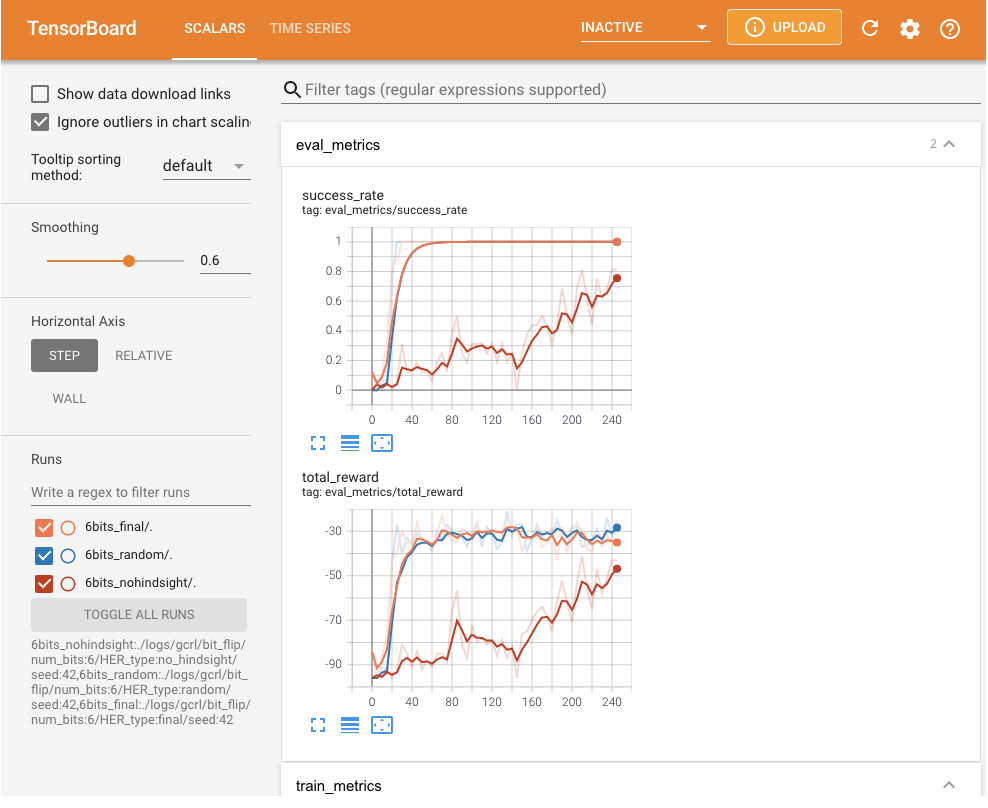

In [4]:
%tensorboard --logdir_spec='15bits_nohindsight':./logs/gcrl/bit_flip/num_bits:15/HER_type:no_hindsight/seed:42,'15bits_random':./logs/gcrl/bit_flip/num_bits:15/HER_type:random/seed:42,'15bits_final':./logs/gcrl/bit_flip/num_bits:15/HER_type:final/seed:42        

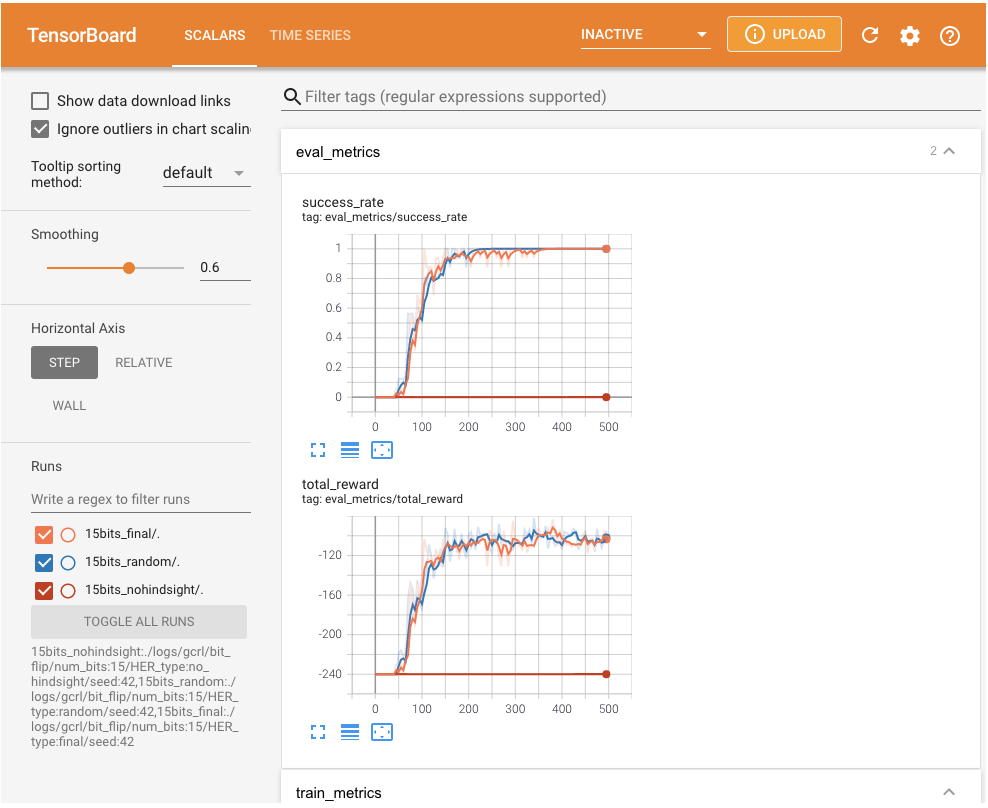

as we see in plots with increase in number of bits problem gets harder and exploration space grows exponentialy and as stated in paper for n>40 standard RL algorithms fail. in n=6 we see that problem is getting close to a solution but HER dramaticaly increases sample efficieny and time to reach succes rate=1. in n=15 we see that problem has very poor sample efficieny and performance but HER can solve problem after 100 epochs. probably for n>40 also HER will make learning possible even with this sparse rewards in reasonable amount of time. this problem has a special structure with combinatorical state space growth in contrast with linear growth of goal space. so experience replay with very small number of replays for that small number of goals can be very benefical. also we see that using final state of trajectory as goal is enough for having a good algorithm performance and in this task due to a semi-indepences between features of states, sampling a few goals along traj doesnt provide any extra benefit since each goal could increase skill of agent in changing all bits.

#Problem 3: Analyzing HER for Sawyer Reach (7 points)


If implemented correctly, HER should work for the second environment, Sawyer Reach.
Compare the performance of the Sawyer arm with and without HER. Run the following
commands:

In [19]:
main(env='sawyer_reach', num_epochs=1000, her_type='no_hindsight')

/usr/local/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


logging experiment at: ./logs/gcrl/sawyer_reach/HER_type:no_hindsight/seed:42
Epoch: 0 Cumulative reward: -139.88275915995166 Success rate: 0.0 Mean loss: 0.006766919046640396
Epoch: 5 Cumulative reward: -75.56259454436378 Success rate: 0.0625 Mean loss: 0.0027834440115839243
Epoch: 10 Cumulative reward: -75.60647701868751 Success rate: 0.0 Mean loss: 0.002455267123878002
Epoch: 15 Cumulative reward: -57.079465619396565 Success rate: 0.125 Mean loss: 0.0021548704244196415
Epoch: 20 Cumulative reward: -95.39852517763191 Success rate: 0.0625 Mean loss: 0.0020922860130667686
Epoch: 25 Cumulative reward: -70.52585283085601 Success rate: 0.0 Mean loss: 0.0020129939075559378
Epoch: 30 Cumulative reward: -75.39916948609553 Success rate: 0.0625 Mean loss: 0.0019027646631002426
Epoch: 35 Cumulative reward: -66.84603295718475 Success rate: 0.0625 Mean loss: 0.0020777496974915266
Epoch: 40 Cumulative reward: -62.0061450701128 Success rate: 0.1875 Mean loss: 0.001887352205812931
Epoch: 45 Cumulati

Epoch: 400 Cumulative reward: -52.44598562154512 Success rate: 0.25 Mean loss: 0.0006375248194672167
Epoch: 405 Cumulative reward: -40.67198336350308 Success rate: 0.3125 Mean loss: 0.0005847611464560032
Epoch: 410 Cumulative reward: -36.72532254134539 Success rate: 0.375 Mean loss: 0.0006694003823213279
Epoch: 415 Cumulative reward: -35.64061929711761 Success rate: 0.4375 Mean loss: 0.0005839561345055699
Epoch: 420 Cumulative reward: -42.97318676531094 Success rate: 0.1875 Mean loss: 0.0006687797140330076
Epoch: 425 Cumulative reward: -36.10464949559693 Success rate: 0.375 Mean loss: 0.0006800167611800134
Epoch: 430 Cumulative reward: -37.65788350093488 Success rate: 0.5 Mean loss: 0.0006755843060091138
Epoch: 435 Cumulative reward: -32.17671051737126 Success rate: 0.4375 Mean loss: 0.0007512241718359292
Epoch: 440 Cumulative reward: -37.47870713468018 Success rate: 0.5 Mean loss: 0.0008293585851788521
Epoch: 445 Cumulative reward: -44.750008139494796 Success rate: 0.4375 Mean loss: 0

Epoch: 800 Cumulative reward: -33.48188769106916 Success rate: 0.5625 Mean loss: 0.0005473706987686455
Epoch: 805 Cumulative reward: -34.28237507496603 Success rate: 0.5 Mean loss: 0.0005084763397462666
Epoch: 810 Cumulative reward: -36.51417887660699 Success rate: 0.5 Mean loss: 0.0005790108698420227
Epoch: 815 Cumulative reward: -33.6451817020459 Success rate: 0.5625 Mean loss: 0.0004398399614728987
Epoch: 820 Cumulative reward: -32.74590314168761 Success rate: 0.5625 Mean loss: 0.00042452989146113396
Epoch: 825 Cumulative reward: -35.56872120026615 Success rate: 0.625 Mean loss: 0.0005119546549394727
Epoch: 830 Cumulative reward: -34.40419189806715 Success rate: 0.6875 Mean loss: 0.0004577207437250763
Epoch: 835 Cumulative reward: -44.960207727393666 Success rate: 0.25 Mean loss: 0.00041101808892562985
Epoch: 840 Cumulative reward: -27.921189240624347 Success rate: 0.5625 Mean loss: 0.0004561486712191254
Epoch: 845 Cumulative reward: -38.526446248370995 Success rate: 0.4375 Mean los

In [20]:
main(env='sawyer_reach', num_epochs=1000, her_type='final')

logging experiment at: ./logs/gcrl/sawyer_reach/HER_type:final/seed:42
Epoch: 0 Cumulative reward: -142.61299235770045 Success rate: 0.0 Mean loss: 0.006376178469508886
Epoch: 5 Cumulative reward: -64.08765463049161 Success rate: 0.0625 Mean loss: 0.0029177614487707615
Epoch: 10 Cumulative reward: -94.54654364588642 Success rate: 0.0 Mean loss: 0.00290471687912941
Epoch: 15 Cumulative reward: -82.01611851755811 Success rate: 0.0625 Mean loss: 0.002862161723896861
Epoch: 20 Cumulative reward: -77.83396471614648 Success rate: 0.0625 Mean loss: 0.003046475350856781
Epoch: 25 Cumulative reward: -78.48749049355774 Success rate: 0.0625 Mean loss: 0.0035776596050709486
Epoch: 30 Cumulative reward: -71.756403536073 Success rate: 0.0 Mean loss: 0.005687823984771967
Epoch: 35 Cumulative reward: -68.74830699378249 Success rate: 0.125 Mean loss: 0.005324403755366802
Epoch: 40 Cumulative reward: -83.56179304452455 Success rate: 0.0625 Mean loss: 0.007660471834242344
Epoch: 45 Cumulative reward: -99

Epoch: 405 Cumulative reward: -39.60470818627584 Success rate: 0.1875 Mean loss: 0.0011826168047264218
Epoch: 410 Cumulative reward: -40.07739520396052 Success rate: 0.5625 Mean loss: 0.0011377888731658459
Epoch: 415 Cumulative reward: -39.88336240052179 Success rate: 0.5 Mean loss: 0.001021290197968483
Epoch: 420 Cumulative reward: -40.559118674278864 Success rate: 0.3125 Mean loss: 0.0011250741081312299
Epoch: 425 Cumulative reward: -47.8831187727831 Success rate: 0.4375 Mean loss: 0.00104364356957376
Epoch: 430 Cumulative reward: -36.31517189261708 Success rate: 0.4375 Mean loss: 0.0010683274595066905
Epoch: 435 Cumulative reward: -41.477338028817336 Success rate: 0.3125 Mean loss: 0.000959564174991101
Epoch: 440 Cumulative reward: -45.602729976371535 Success rate: 0.4375 Mean loss: 0.0009659306961111724
Epoch: 445 Cumulative reward: -35.40386573776151 Success rate: 0.5 Mean loss: 0.0010584992123767734
Epoch: 450 Cumulative reward: -35.20372714404175 Success rate: 0.5625 Mean loss: 

Epoch: 810 Cumulative reward: -19.340751665065255 Success rate: 1.0 Mean loss: 0.0006341173429973423
Epoch: 815 Cumulative reward: -27.80857712464111 Success rate: 1.0 Mean loss: 0.0005993726663291454
Epoch: 820 Cumulative reward: -30.655088650894314 Success rate: 0.875 Mean loss: 0.0005392103339545429
Epoch: 825 Cumulative reward: -26.397144493159125 Success rate: 0.9375 Mean loss: 0.0005416875937953591
Epoch: 830 Cumulative reward: -31.171625856677274 Success rate: 0.8125 Mean loss: 0.0006646757246926427
Epoch: 835 Cumulative reward: -20.882464317894748 Success rate: 0.8125 Mean loss: 0.0005658242153003812
Epoch: 840 Cumulative reward: -27.202469880785866 Success rate: 0.8125 Mean loss: 0.0005456334911286831
Epoch: 845 Cumulative reward: -25.125256161920113 Success rate: 1.0 Mean loss: 0.0005709856050089002
Epoch: 850 Cumulative reward: -21.90935165037571 Success rate: 0.9375 Mean loss: 0.0006223964737728238
Epoch: 855 Cumulative reward: -34.38924472451235 Success rate: 0.6875 Mean l


<font color='red'>
a) Submit the tensorboard screenshot comparing the eval metrics in your report.</font>


<font color='red'>
b) Discuss your findings: Compare the role of HER in Bit Flipping Environment and
Sawyer Reach. Comment on the differences between the contribution of HER, if any
</font>

In [5]:
%tensorboard --logdir_spec='sawyer_reach_nohindsight':./logs/gcrl/sawyer_reach/HER_type:no_hindsight/seed:42,'sawyer_reach_final':./logs/gcrl/sawyer_reach/HER_type:final/seed:42

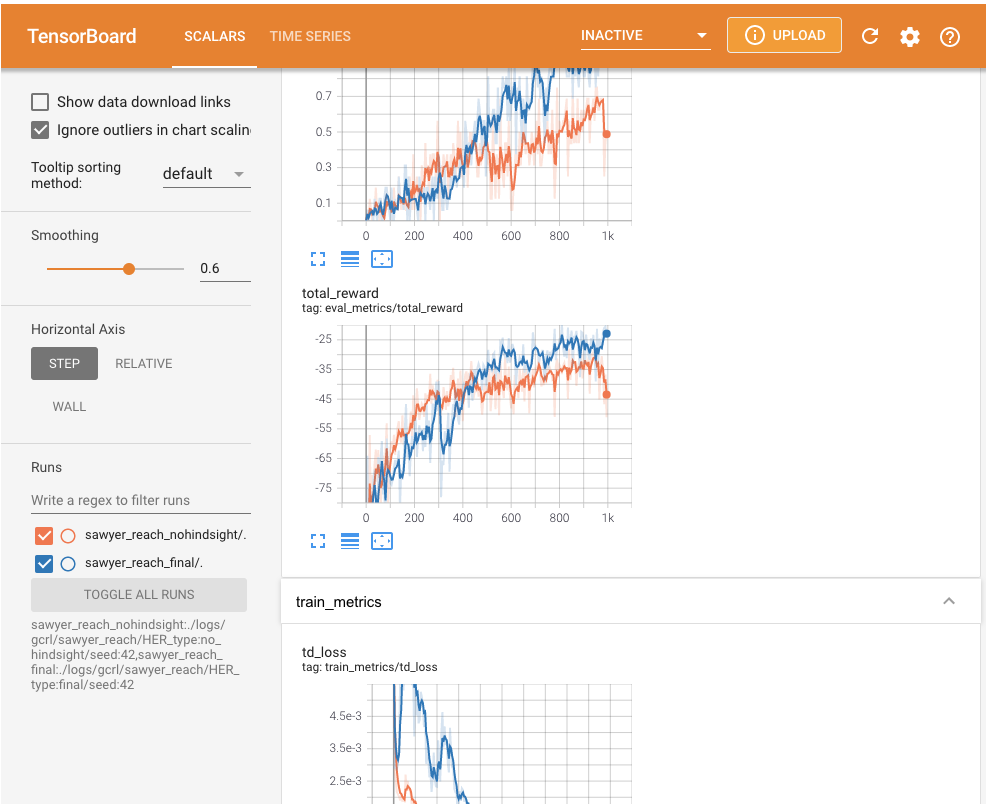

we see that HER can improve sample efficieny and boost learning path in high dimensional (and even continous) spaces with sparse goals. also comparing too bitflip here state space of problem is more coherent and HER doesnt have unusual positive effect (like in 15 bits bitflip env) but improving speed of convergence and sample efficiency of agent.